In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.2.0
Torchvision Version:  0.4.0a0


In [4]:
data_dir = "/home/nikita/PycharmProjects/hymenoptera_data"
num_classes = 2
batch_size = 8
num_epochs = 15
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [6]:
#image_net = models.alexnet(pretrained=True)
#print(image_net)

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [7]:


use_pretrained = False
feature_extract = True
model_ft = models.alexnet(pretrained=use_pretrained)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
input_size = 224

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Initializing Datasets and Dataloaders...


In [8]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)



Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [11]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.6926 Acc: 0.5451
val Loss: 0.6925 Acc: 0.6667

Epoch 1/14
----------
train Loss: 0.6932 Acc: 0.4877
val Loss: 0.6928 Acc: 0.4771

Epoch 2/14
----------
train Loss: 0.6931 Acc: 0.4795
val Loss: 0.6927 Acc: 0.5033

Epoch 3/14
----------
train Loss: 0.6929 Acc: 0.5123
val Loss: 0.6930 Acc: 0.4575

Epoch 4/14
----------
train Loss: 0.6928 Acc: 0.5082
val Loss: 0.6928 Acc: 0.4575

Epoch 5/14
----------
train Loss: 0.6926 Acc: 0.5451
val Loss: 0.6932 Acc: 0.4575

Epoch 6/14
----------
train Loss: 0.6928 Acc: 0.5246
val Loss: 0.6932 Acc: 0.4575

Epoch 7/14
----------
train Loss: 0.6925 Acc: 0.5246
val Loss: 0.6925 Acc: 0.4967

Epoch 8/14
----------
train Loss: 0.6928 Acc: 0.4836
val Loss: 0.6932 Acc: 0.4575

Epoch 9/14
----------
train Loss: 0.6928 Acc: 0.5205
val Loss: 0.6929 Acc: 0.4575

Epoch 10/14
----------
train Loss: 0.6922 Acc: 0.5533
val Loss: 0.6931 Acc: 0.4575

Epoch 11/14
----------
train Loss: 0.6926 Acc: 0.5410
val Loss: 0.6933 Acc: 0.4575

Ep

Epoch 0/14
----------
train Loss: 0.6926 Acc: 0.4918
val Loss: 0.6923 Acc: 0.6340

Epoch 1/14
----------
train Loss: 0.6926 Acc: 0.5533
val Loss: 0.6927 Acc: 0.5033

Epoch 2/14
----------
train Loss: 0.6932 Acc: 0.5164
val Loss: 0.6930 Acc: 0.4575

Epoch 3/14
----------
train Loss: 0.6928 Acc: 0.5287
val Loss: 0.6931 Acc: 0.4575

Epoch 4/14
----------
train Loss: 0.6927 Acc: 0.5000
val Loss: 0.6921 Acc: 0.6928

Epoch 5/14
----------
train Loss: 0.6924 Acc: 0.5410
val Loss: 0.6926 Acc: 0.4902

Epoch 6/14
----------
train Loss: 0.6921 Acc: 0.5410
val Loss: 0.6928 Acc: 0.4575

Epoch 7/14
----------
train Loss: 0.6922 Acc: 0.5902
val Loss: 0.6926 Acc: 0.4641

Epoch 8/14
----------
train Loss: 0.6922 Acc: 0.5533
val Loss: 0.6924 Acc: 0.4967

Epoch 9/14
----------
train Loss: 0.6928 Acc: 0.5082
val Loss: 0.6931 Acc: 0.4575

Epoch 10/14
----------
train Loss: 0.6929 Acc: 0.5410
val Loss: 0.6931 Acc: 0.4575

Epoch 11/14
----------
train Loss: 0.6925 Acc: 0.5943
val Loss: 0.6925 Acc: 0.4706

Ep

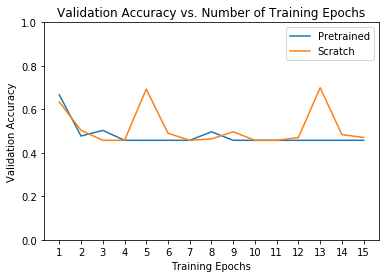

In [12]:
# Initialize the non-pretrained version of the model used for this run
scratch_model = model_ft
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()
